In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [2]:
tf.enable_eager_execution()

In [3]:
print("Tensorflow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Tensorflow version: 1.8.0
Eager execution: True


In [4]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url), origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /Users/schlenga/.keras/datasets/iris_training.csv


In [5]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [6]:
def parse_csv(line):
    example_defaults = [[0.],[0.],[0.],[0.],[0]]
    parsed_line = tf.decode_csv(line, example_defaults)
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

In [7]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size = 1000)
train_dataset = train_dataset.batch(32)

features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([7.4 2.8 6.1 1.9], shape=(4,), dtype=float32)
example label: tf.Tensor(2, shape=(), dtype=int32)


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

In [9]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [10]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [11]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in train_dataset:
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables), global_step = tf.train.get_or_create_global_step())
        epoch_loss_avg(loss(model, x, y))
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))
        

Epoch 000: Loss: 1.403, Accuracy: 30.000%
Epoch 050: Loss: 0.376, Accuracy: 94.167%
Epoch 100: Loss: 0.224, Accuracy: 98.333%
Epoch 150: Loss: 0.148, Accuracy: 98.333%
Epoch 200: Loss: 0.107, Accuracy: 98.333%


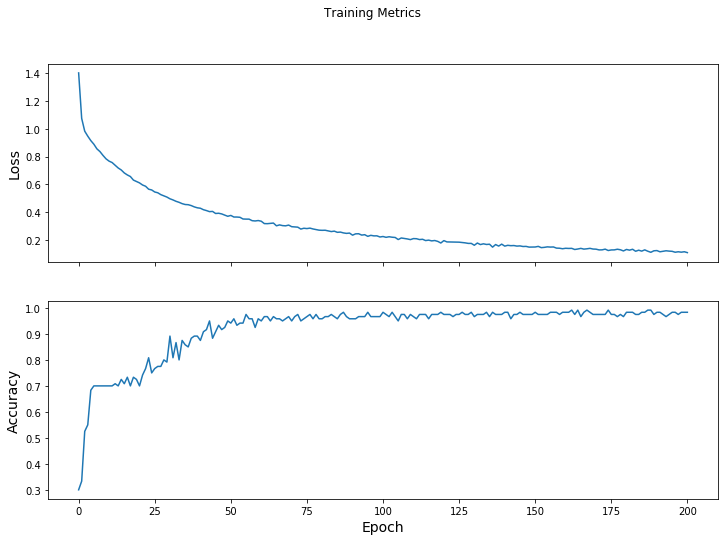

In [12]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12,8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [13]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url), origin = test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [14]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)
    
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%
